#**한국어 BERT 언어모델을 활용한 Named Entity Recognition(NER) finetuning**

개체명 인식: **사람(Person, PS), 장소(Location, LC), 기관(Organization, OG), 날짜(Date, DT)**, 이 외에도 분야에 따라 약물 명, 임상 절차, 생물학적 단백질 등과 같은 명명된(named) 개체를 텍스트로 식별하는 작업


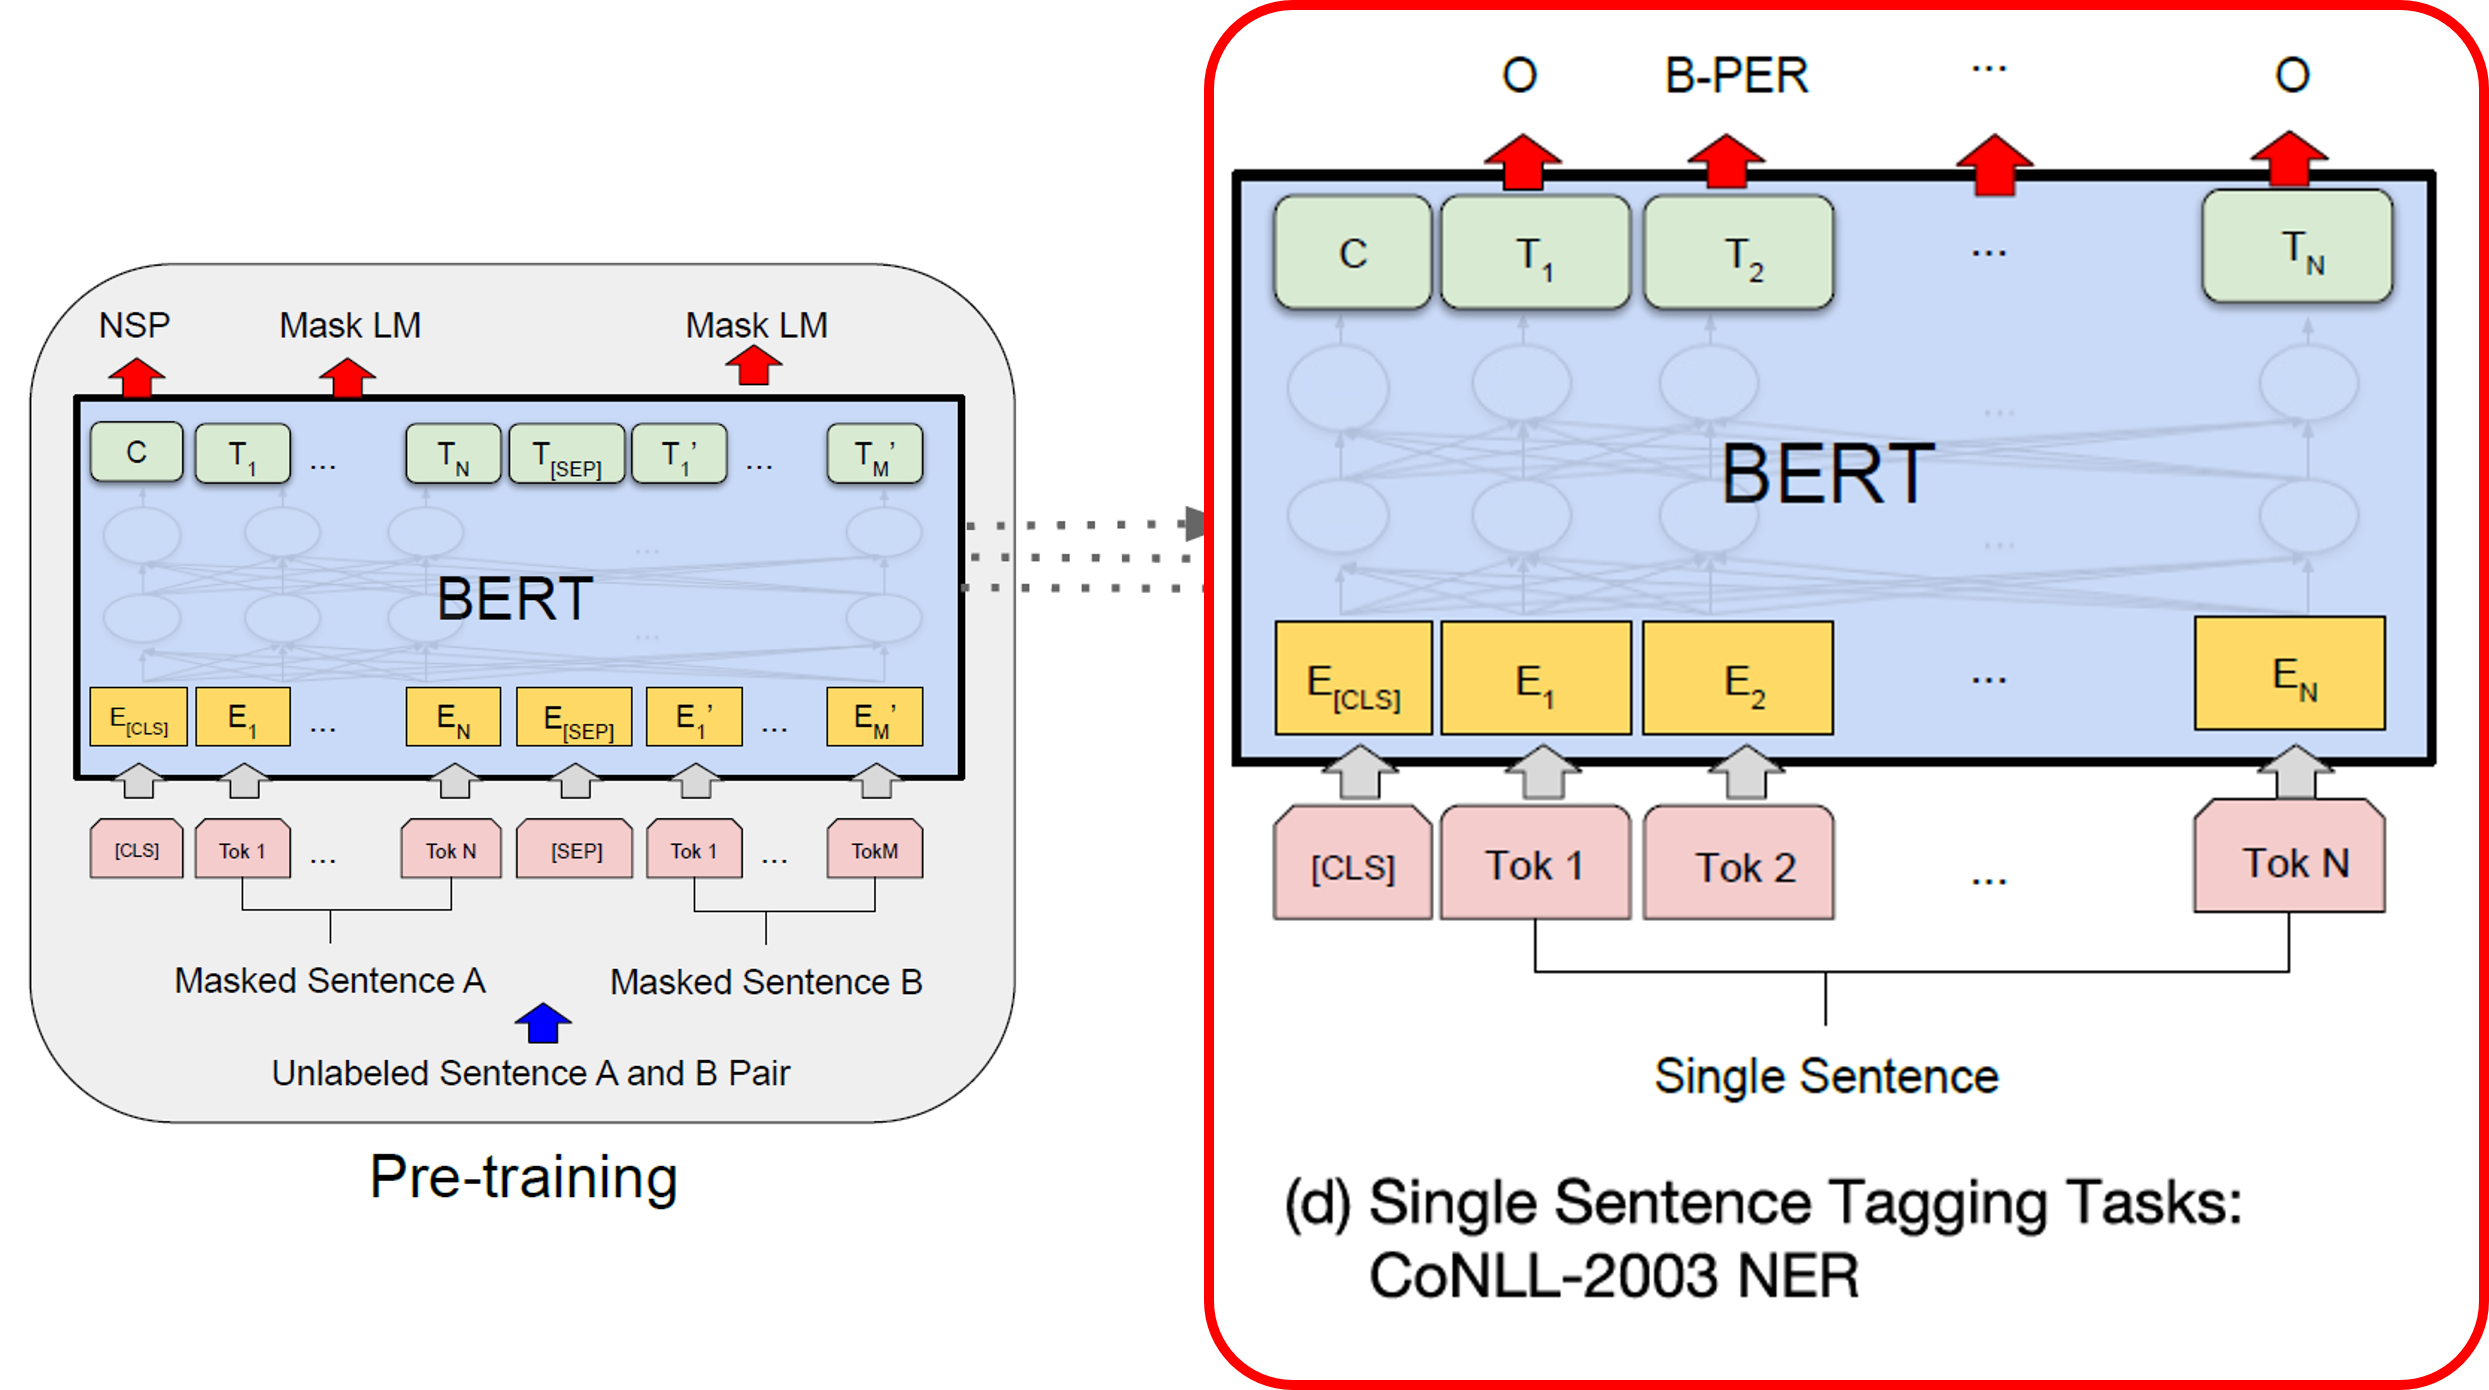

### 언어모델 BERT 기반 NER 시스템

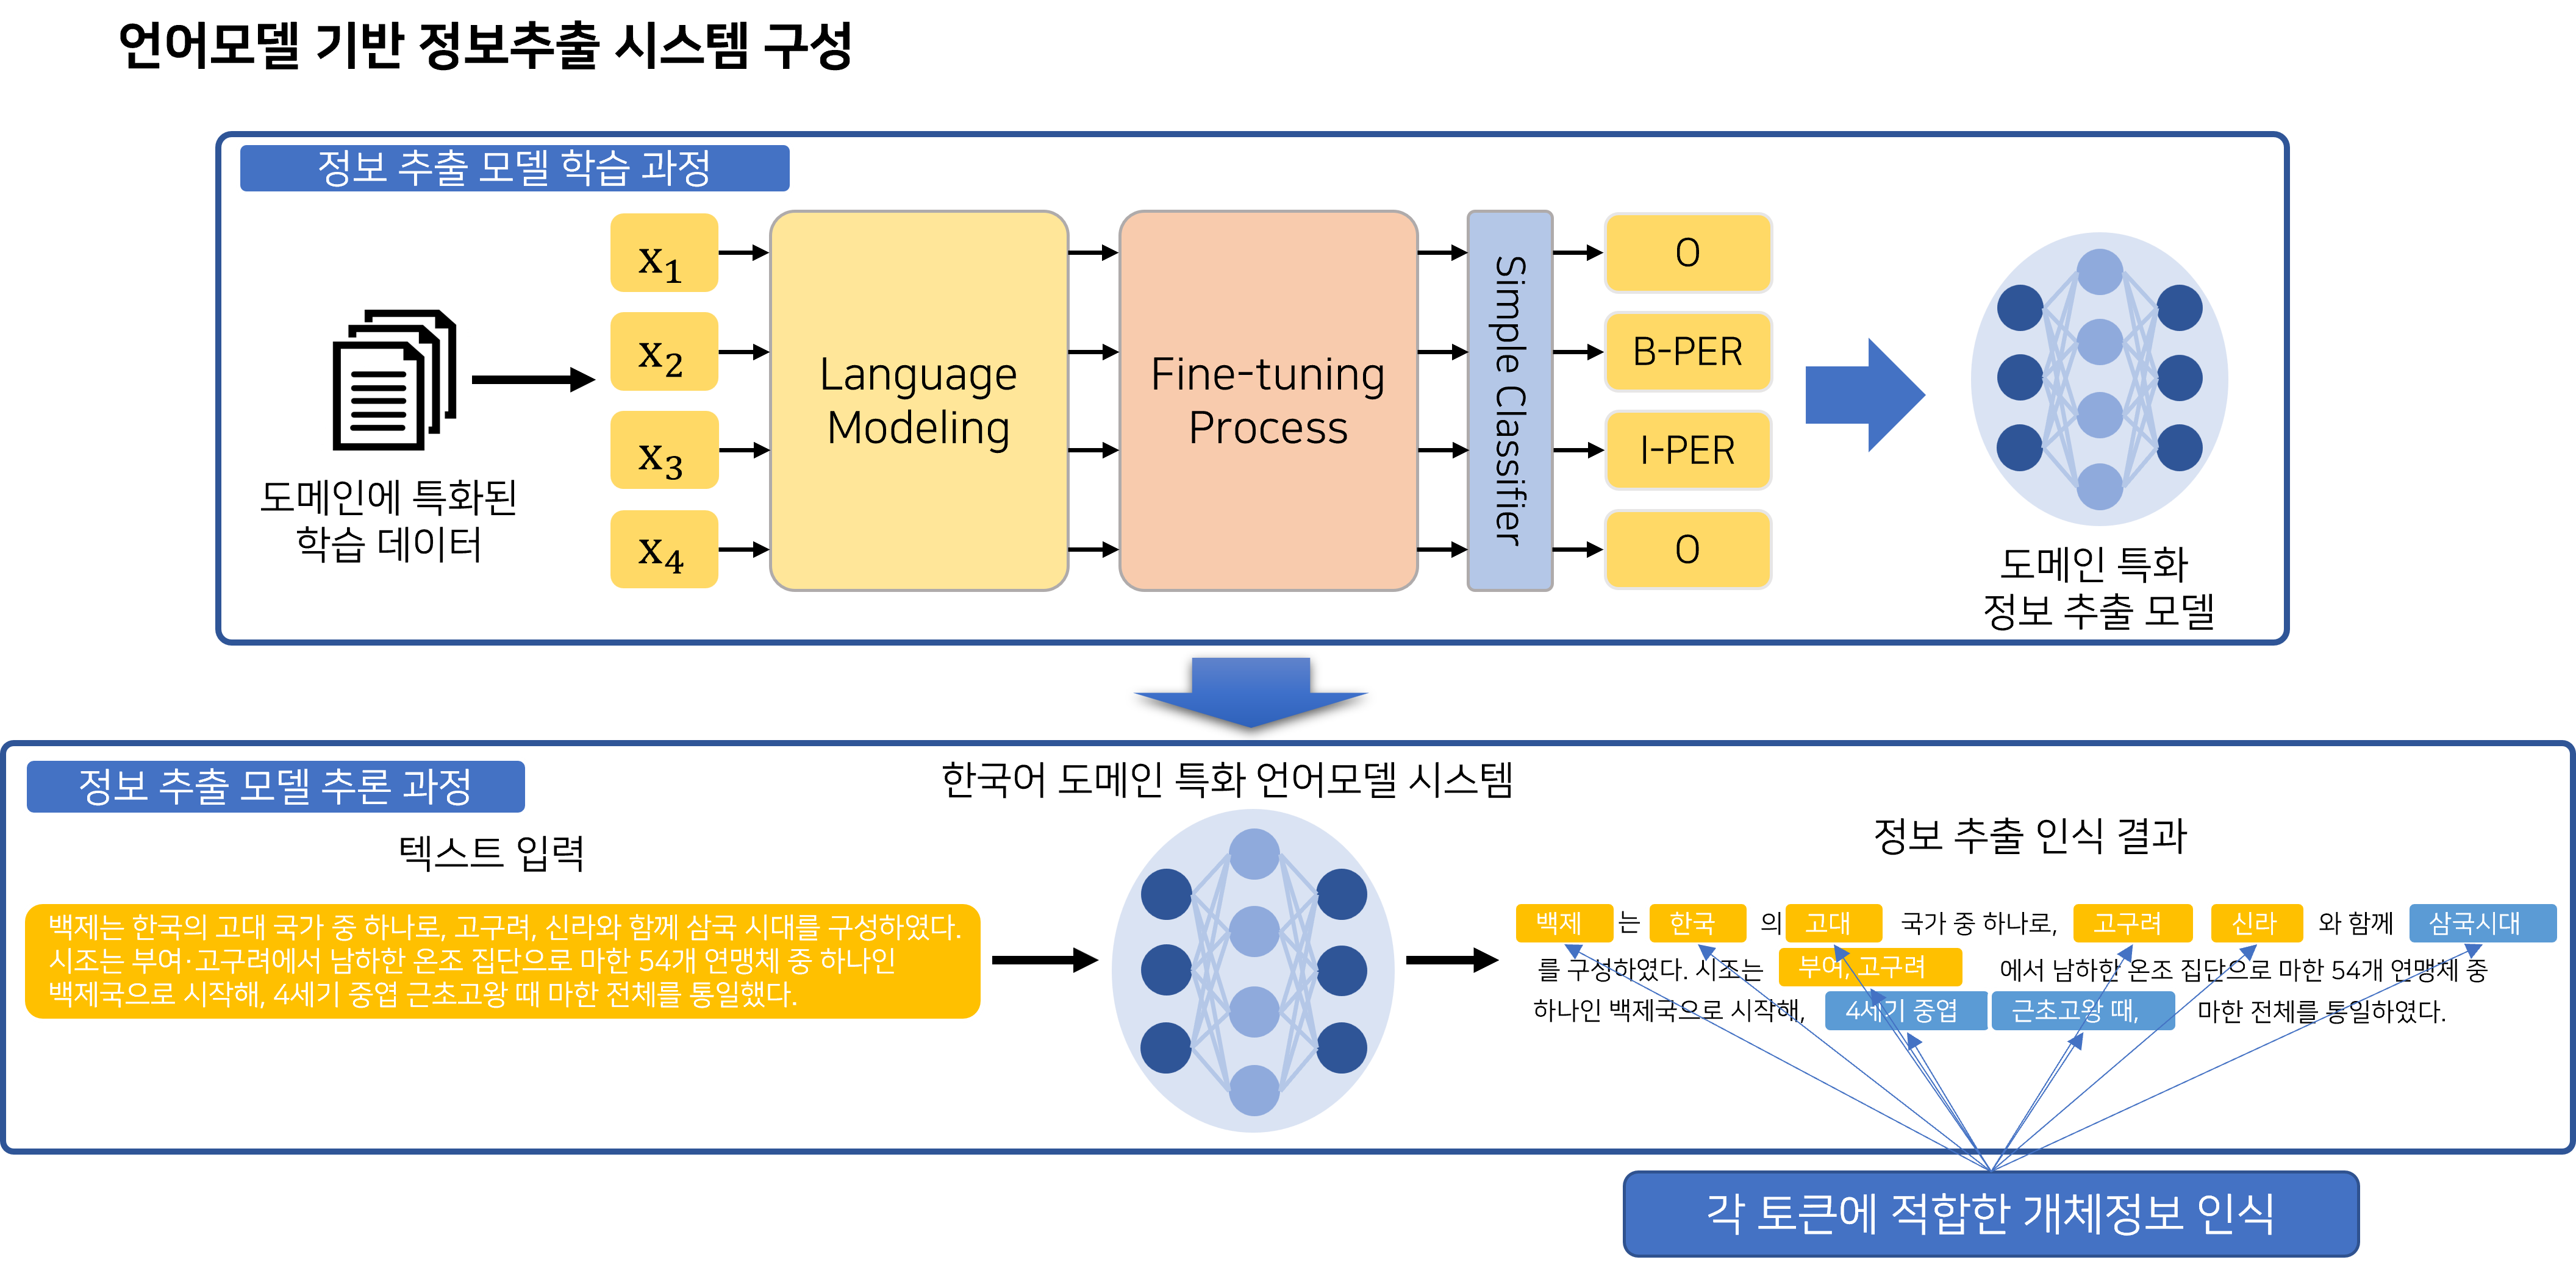

### 네이버 & 창원대 NLP Challenge의 NER 데이터셋

Github: [https://github.com/naver/nlp-challenge/](https://github.com/naver/nlp-challenge/)

리더보드: [https://air.changwon.ac.kr/?page_id=10](https://air.changwon.ac.kr/?page_id=10)

- NER 코퍼스는 다음의 14개의 분류 카테고리(클래스)로 레이블링된 형태

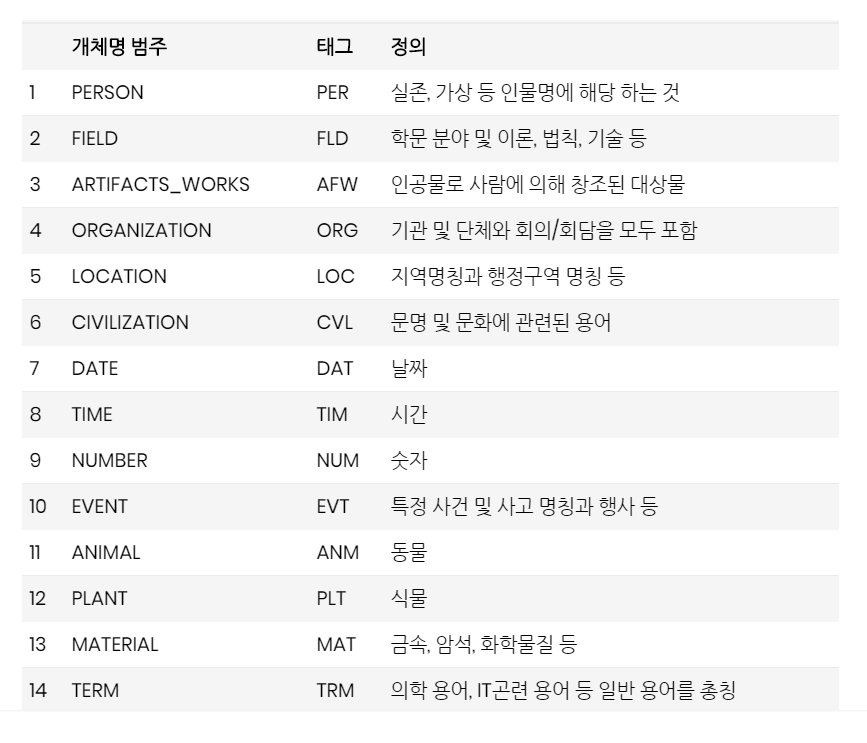

[Reference]

한국어 BERT 모델 [https://github.com/monologg/KoBERT-NER/](https://github.com/monologg/KoBERT-NER/)

## 전체 순서

1.   데이터 다운로드
2.   토크나이저 초기화
3.   사전학습된 BERT 언어모델 호출 및 모델 초기화
4.   모델 성능 평가
5.   실습해보기


## 데이터 다운로드 - 공유된 링크의 Data/NER/data/ 경로에 있는 다음의 파일을 ./data 안에 저장해주시기 바랍니다.

1. train.tsv
2. test.tsv
3. label.txt


In [1]:
!mkdir data

### 필요 유틸리티 정의

In [2]:
!pip install transformers==4.30.0    # Hugginface transformers 설치?
!pip install torch
!pip install sentencepiece   # Sentencepiece 서브워드 분절

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.3
    Uninstalling transformers-4.48.3:
      Successfully uninstalled transformers-4.48.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.30.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install seqeval==0.0.13
!pip install easydict

  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-0.0.13-py3-none-any.whl size=7441 sha256=646a7eaf5a648ab0baf3cd5208eb00ac5318b4f2053e5ad134c900f0ba0f0c60
  Stored in directory: /root/.cache/pip/wheels/da/4a/3f/3a9e17b79962a967cdcd8e8c296a9045cf077e8665867f5dca
Successfully built seqeval


## KoBERT Tokenizer

In [5]:
VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}


PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
    }
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
}

SPIECE_UNDERLINE = u'▁'

In [6]:
from transformers import PreTrainedTokenizer
import unicodedata

class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """

    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

In [7]:
import os
import random
import logging

import torch
import numpy as np
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report


from transformers import (
    BertConfig,
    BertTokenizer,
    PreTrainedTokenizer,
    BertForTokenClassification
)


MODEL_CLASSES = {
    'kobert': (BertConfig, BertForTokenClassification, KoBertTokenizer),
    'bert': (BertConfig, BertForTokenClassification, BertTokenizer),
}

def get_test_texts(args):
    texts = []
    with open(os.path.join(args.data_dir, args.test_file), 'r', encoding='utf-8') as f:
        for line in f:
            text, _ = line.split('\t')
            text = text.split()
            texts.append(text)

    return texts


def get_labels(args):
    return [label.strip() for label in open(os.path.join(args.data_dir, args.label_file), 'r', encoding='utf-8')]


def load_tokenizer(args):
    return MODEL_CLASSES[args.model_type][2].from_pretrained(args.model_name_or_path)


def init_logger():
    logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                        datefmt='%m/%d/%Y %H:%M:%S',
                        level=logging.INFO)


def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if not args.no_cuda and torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)


def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return f1_pre_rec(labels, preds)


def f1_pre_rec(labels, preds):
    return {
        "precision": precision_score(labels, preds, suffix=True),
        "recall": recall_score(labels, preds, suffix=True),
        "f1": f1_score(labels, preds, suffix=True)
    }


def show_report(labels, preds):
    return classification_report(labels, preds, suffix=True)

## 데이터 전처리

### 데이터 캐싱함수(load_and_cache_examples)

- 네이버 NER 데이터셋 처리를 위한 **NaverNERProcessor** 클래스
    - 세부 데이터 처리를 위해 필요한 **InputExample, InputFeatures** 클래스

In [8]:
import os
import copy
import json
import logging

import torch
from torch.utils.data import TensorDataset


logger = logging.getLogger(__name__)

class InputExample(object):
    """
    A single training/test example for simple sequence classification.

    Args:
        guid: Unique id for the example.
        words: list. The words of the sequence.
        labels: (Optional) list. The slot labels of the example.
    """

    def __init__(self, guid, words, labels):
        self.guid = guid
        self.words = words
        self.labels = labels

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, attention_mask, token_type_ids, label_ids):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.label_ids = label_ids

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"


In [9]:
!head ./data/test.tsv

나아가 한 스트로크를 하는 제한시간에 대한 지침도 있다 .	O NUM-B NUM-I O O O O O O
그건 관두 영업적 득공을 버리고 퇴은을 원하는 엘레나 대행 궐녀를 닮은 여인들을 교련 시켜서 ．	O O O O O O O PER-B O O O CVL-B O O O
송인영은 5년 근화향에서 개최된 CJ나인브릿지클래식 토요돌봄으로 'LPGA 직행티킷'을 거머쥐었던 투표권 .	PER-B DAT-B LOC-B O EVT-B CVL-B ORG-B O O CVL-B O
역전패' 단국 월드리그 7연패…장영달회장 인퇴	O EVT-B EVT-I NUM-B O
‘국내 최대 통신그룹인 KT호의 선장은 누가 될까 . '	O O O ORG-B CVL-B O O O O
해자부래기 등을 연출한 무하마드 무설탕껌의 신작인 이 소작은 특유의 희극적한 배역으로 돌아온 제향기르를 비롯해서 막강한 내공을 자랑하는 일원들의 다면으로 관념을 끌고 있습니다 .	O O O PER-B CVL-B O O O O O O O PER-B O O O O CVL-B O O O O O
다들 보면, 보지는 못하더라도 안부전화 하고 에베레스트에서 한류스타들이라고, 잘나가는 분들이어서 개개인적으로 감정이 좋고 그렇습니다 .	O O O O O O LOC-B CVL-B O O O O O O O
-5명의 해외 익명 부녀회원이 합동 연출, 에로스라는 분수로 7가지의 일담을 담아낸 무비 오감도 .	NUM-B O O CVL-B O O PER-B O NUM-B O O FLD-B O O
칼럼의 제호를 ‘믹스트존’이 아니라 ‘철망 밖’이라고 해야겠다 .	O O O O O O O O
한편 물음이 있다면 공중이 필수하다는 거예요 .	NUM-B O O O O O O


In [10]:
class NaverNerProcessor(object):
    """Processor for the Naver NER data set """

    def __init__(self, args):
        self.args = args
        self.labels_lst = get_labels(args)

    @classmethod
    def _read_file(cls, input_file):
        """Read tsv file, and return words and label as list"""
        with open(input_file, "r", encoding="utf-8") as f:
            lines = []
            for line in f:
                lines.append(line.strip())
            return lines

    def _create_examples(self, dataset, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, data) in enumerate(dataset):
            words, labels = data.split('\t')
            words = words.split()
            labels = labels.split()
            guid = "%s-%s" % (set_type, i)

            labels_idx = []
            for label in labels:
                labels_idx.append(self.labels_lst.index(label) if label in self.labels_lst else self.labels_lst.index("UNK"))

            assert len(words) == len(labels_idx)

            if i % 10000 == 0:
                logger.info(data)
            examples.append(InputExample(guid=guid, words=words, labels=labels_idx))
        return examples

    def get_examples(self, mode):
        """
        Args:
            mode: train, dev, test
        """
        file_to_read = None
        if mode == 'train':
            file_to_read = self.args.train_file
        elif mode == 'dev':
            file_to_read = self.args.dev_file
        elif mode == 'test':
            file_to_read = self.args.test_file

        logger.info("LOOKING AT {}".format(os.path.join(self.args.data_dir, file_to_read)))
        return self._create_examples(self._read_file(os.path.join(self.args.data_dir, file_to_read)), mode)



In [11]:
def convert_examples_to_features(examples, max_seq_len, tokenizer,
                                 pad_token_label_id=-100,
                                 cls_token_segment_id=0,
                                 pad_token_segment_id=0,
                                 sequence_a_segment_id=0,
                                 mask_padding_with_zero=True):
    # Setting based on the current model type
    cls_token = tokenizer.cls_token
    sep_token = tokenizer.sep_token
    unk_token = tokenizer.unk_token
    pad_token_id = tokenizer.pad_token_id

    print("convert_examples_to_features")

    features = []
    for (ex_index, example) in enumerate(examples):
        if ex_index % 5000 == 0:
            logger.info("Writing example %d of %d" % (ex_index, len(examples)))

        # Tokenize word by word (for NER)
        tokens = []
        label_ids = []
        for word, slot_label in zip(example.words, example.labels):
            word_tokens = tokenizer.tokenize(word)
            if not word_tokens:
                word_tokens = [unk_token]  # For handling the bad-encoded word
            tokens.extend(word_tokens)
            # Use the real label id for the first token of the word, and padding ids for the remaining tokens
            label_ids.extend([int(slot_label)] + [pad_token_label_id] * (len(word_tokens) - 1))

        # Account for [CLS] and [SEP]
        special_tokens_count = 2
        if len(tokens) > max_seq_len - special_tokens_count:
            tokens = tokens[: (max_seq_len - special_tokens_count)]
            label_ids = label_ids[: (max_seq_len - special_tokens_count)]

        # Add [SEP] token
        tokens += [sep_token]
        label_ids += [pad_token_label_id]
        token_type_ids = [sequence_a_segment_id] * len(tokens)

        # Add [CLS] token
        tokens = [cls_token] + tokens
        label_ids = [pad_token_label_id] + label_ids
        token_type_ids = [cls_token_segment_id] + token_type_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        attention_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_len - len(input_ids)
        input_ids = input_ids + ([pad_token_id] * padding_length)
        attention_mask = attention_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
        token_type_ids = token_type_ids + ([pad_token_segment_id] * padding_length)
        label_ids = label_ids + ([pad_token_label_id] * padding_length)

        assert len(input_ids) == max_seq_len, "Error with input length {} vs {}".format(len(input_ids), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_ids) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_ids), max_seq_len)
        assert len(label_ids) == max_seq_len, "Error with slot labels length {} vs {}".format(len(label_ids), max_seq_len)

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % example.guid)
            logger.info("tokens: %s" % " ".join([str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("attention_mask: %s" % " ".join([str(x) for x in attention_mask]))
            logger.info("token_type_ids: %s" % " ".join([str(x) for x in token_type_ids]))
            logger.info("label: %s " % " ".join([str(x) for x in label_ids]))

        features.append(
            InputFeatures(input_ids=input_ids,
                          attention_mask=attention_mask,
                          token_type_ids=token_type_ids,
                          label_ids=label_ids
                          ))

    return features

In [12]:
processors = {
    "naver-ner": NaverNerProcessor,
}

def load_and_cache_examples(args, tokenizer, mode):
    processor = processors[args.task](args)

    # Load data features from cache or dataset file
    cached_file_name = 'cached_{}_{}_{}_{}'.format(
        args.task, list(filter(None, args.model_name_or_path.split("/"))).pop(), args.max_seq_len, mode)

    pad_token_label_id = torch.nn.CrossEntropyLoss().ignore_index
    cached_features_file = os.path.join(args.data_dir, cached_file_name)

    if os.path.exists(cached_features_file):
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
    else:
        logger.info("Creating features from dataset file at %s", args.data_dir)
        if mode == "train":
            examples = processor.get_examples("train")
        elif mode == "dev":
            examples = processor.get_examples("dev")
        elif mode == "test":
            examples = processor.get_examples("test")
        else:
            raise Exception("For mode, Only train, dev, test is available")

        features = convert_examples_to_features(examples, args.max_seq_len, tokenizer, pad_token_label_id=pad_token_label_id)
        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)



    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_ids for f in features], dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_label_ids)
    return dataset

## 모델 학습 Trainer

In [13]:
import os
import shutil
import logging
from tqdm import tqdm, trange

import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup

logger = logging.getLogger(__name__)


class Trainer(object):
    def __init__(self, args, train_dataset=None, dev_dataset=None, test_dataset=None):
        self.args = args
        self.train_dataset = train_dataset
        self.dev_dataset = dev_dataset
        self.test_dataset = test_dataset

        self.label_lst = get_labels(args)
        self.num_labels = len(self.label_lst)
        # Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
        self.pad_token_label_id = torch.nn.CrossEntropyLoss().ignore_index

        self.config_class, self.model_class, _ = MODEL_CLASSES[args.model_type]

        self.config = self.config_class.from_pretrained(args.model_name_or_path,
                                                        num_labels=self.num_labels,
                                                        finetuning_task=args.task,
                                                        id2label={str(i): label for i, label in enumerate(self.label_lst)},
                                                        label2id={label: i for i, label in enumerate(self.label_lst)})
        self.model = self.model_class.from_pretrained(args.model_name_or_path, config=self.config)

        # GPU or CPU
        self.device = "cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu"
        self.model.to(self.device)

        self.test_texts = None
        if args.write_pred:
            self.test_texts = get_test_texts(args)
            # Empty the original prediction files
            if os.path.exists(args.pred_dir):
                shutil.rmtree(args.pred_dir)

    def train(self):
        train_sampler = RandomSampler(self.train_dataset)
        train_dataloader = DataLoader(self.train_dataset, sampler=train_sampler, batch_size=self.args.train_batch_size)

        if self.args.max_steps > 0:
            t_total = self.args.max_steps
            self.args.num_train_epochs = self.args.max_steps // (len(train_dataloader) // self.args.gradient_accumulation_steps) + 1
        else:
            t_total = len(train_dataloader) // self.args.gradient_accumulation_steps * self.args.num_train_epochs

        # Prepare optimizer and schedule (linear warmup and decay)
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'weight_decay': self.args.weight_decay},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.args.learning_rate, eps=self.args.adam_epsilon)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=self.args.warmup_steps, num_training_steps=t_total)

        # Train!
        logger.info("***** Running training *****")
        logger.info("  Num examples = %d", len(self.train_dataset))
        logger.info("  Num Epochs = %d", self.args.num_train_epochs)
        logger.info("  Total train batch size = %d", self.args.train_batch_size)
        logger.info("  Gradient Accumulation steps = %d", self.args.gradient_accumulation_steps)
        logger.info("  Total optimization steps = %d", t_total)
        logger.info("  Logging steps = %d", self.args.logging_steps)
        logger.info("  Save steps = %d", self.args.save_steps)

        global_step = 0
        tr_loss = 0.0
        self.model.zero_grad()

        train_iterator = trange(int(self.args.num_train_epochs), desc="Epoch")

        for _ in train_iterator:
            epoch_iterator = tqdm(train_dataloader, desc="Iteration")
            for step, batch in enumerate(epoch_iterator):
                self.model.train()
                batch = tuple(t.to(self.device) for t in batch)  # GPU or CPU
                inputs = {'input_ids': batch[0],
                          'attention_mask': batch[1],
                          'labels': batch[3]}
                if self.args.model_type != 'distilkobert':
                    inputs['token_type_ids'] = batch[2]
                outputs = self.model(**inputs)
                loss = outputs[0]

                if self.args.gradient_accumulation_steps > 1:
                    loss = loss / self.args.gradient_accumulation_steps

                loss.backward()

                tr_loss += loss.item()
                if (step + 1) % self.args.gradient_accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.args.max_grad_norm)

                    optimizer.step()
                    scheduler.step()  # Update learning rate schedule
                    self.model.zero_grad()
                    global_step += 1

                    if self.args.logging_steps > 0 and global_step % self.args.logging_steps == 0:
                        self.evaluate("test", global_step)

                    if self.args.save_steps > 0 and global_step % self.args.save_steps == 0:
                        self.save_model()

                if 0 < self.args.max_steps < global_step:
                    epoch_iterator.close()
                    break

            if 0 < self.args.max_steps < global_step:
                train_iterator.close()
                break

        return global_step, tr_loss / global_step

    def evaluate(self, mode, step):
        if mode == 'test':
            dataset = self.test_dataset
        elif mode == 'dev':
            dataset = self.dev_dataset
        else:
            raise Exception("Only dev and test dataset available")

        eval_sampler = SequentialSampler(dataset)
        eval_dataloader = DataLoader(dataset, sampler=eval_sampler, batch_size=self.args.eval_batch_size)

        # Eval!
        logger.info("***** Running evaluation on %s dataset *****", mode)
        logger.info("  Num examples = %d", len(dataset))
        logger.info("  Batch size = %d", self.args.eval_batch_size)
        eval_loss = 0.0
        nb_eval_steps = 0
        preds = None
        out_label_ids = None

        self.model.eval()

        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            batch = tuple(t.to(self.device) for t in batch)
            with torch.no_grad():
                inputs = {'input_ids': batch[0],
                          'attention_mask': batch[1],
                          'labels': batch[3]}
                if self.args.model_type != 'distilkobert':
                    inputs['token_type_ids'] = batch[2]
                outputs = self.model(**inputs)
                tmp_eval_loss, logits = outputs[:2]

                eval_loss += tmp_eval_loss.mean().item()
            nb_eval_steps += 1

            # Slot prediction
            if preds is None:
                preds = logits.detach().cpu().numpy()
                out_label_ids = inputs["labels"].detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

        eval_loss = eval_loss / nb_eval_steps
        results = {
            "loss": eval_loss
        }

        # Slot result
        preds = np.argmax(preds, axis=2)
        slot_label_map = {i: label for i, label in enumerate(self.label_lst)}
        out_label_list = [[] for _ in range(out_label_ids.shape[0])]
        preds_list = [[] for _ in range(out_label_ids.shape[0])]

        for i in range(out_label_ids.shape[0]):
            for j in range(out_label_ids.shape[1]):
                if out_label_ids[i, j] != self.pad_token_label_id:
                    out_label_list[i].append(slot_label_map[out_label_ids[i][j]])
                    preds_list[i].append(slot_label_map[preds[i][j]])

        if self.args.write_pred:
            if not os.path.exists(self.args.pred_dir):
                os.mkdir(self.args.pred_dir)

            with open(os.path.join(self.args.pred_dir, "pred_{}.txt".format(step)), "w", encoding="utf-8") as f:
                for text, true_label, pred_label in zip(self.test_texts, out_label_list, preds_list):
                    for t, tl, pl in zip(text, true_label, pred_label):
                        f.write("{} {} {}\n".format(t, tl, pl))
                    f.write("\n")

        result = compute_metrics(out_label_list, preds_list)
        results.update(result)

        logger.info("***** Eval results *****")
        for key in sorted(results.keys()):
            logger.info("  %s = %s", key, str(results[key]))
        logger.info("\n" + show_report(out_label_list, preds_list))  # Get the report for each tag result

        return results

    def save_model(self):
        # Save model checkpoint (Overwrite)
        if not os.path.exists(self.args.model_dir):
            os.makedirs(self.args.model_dir)
        model_to_save = self.model.module if hasattr(self.model, 'module') else self.model
        model_to_save.save_pretrained(self.args.model_dir)

        # Save training arguments together with the trained model
        torch.save(self.args, os.path.join(self.args.model_dir, 'training_args.bin'))
        logger.info("Saving model checkpoint to %s", self.args.model_dir)

    def load_model(self):
        # Check whether model exists
        if not os.path.exists(self.args.model_dir):
            raise Exception("Model doesn't exists! Train first!")

        try:
            self.model = self.model_class.from_pretrained(self.args.model_dir)
            self.model.to(self.device)
            logger.info("***** Model Loaded *****")
        except:
            raise Exception("Some model files might be missing...")

In [14]:
def main(args):
    init_logger()
    set_seed(args)

    tokenizer = load_tokenizer(args)
    print("=========== Tokenizer loaded ===========")

    train_dataset = None
    dev_dataset = None
    test_dataset = None

    if args.do_train or args.do_eval:
        test_dataset = load_and_cache_examples(args, tokenizer, mode="test")
    if args.do_train:
        train_dataset = load_and_cache_examples(args, tokenizer, mode="train")

    trainer = Trainer(args, train_dataset, dev_dataset, test_dataset)
    print("=========== Model loaded ===========")

    if args.do_train:
        print("=========== START MODEL TRAINING ===========")
        trainer.train()

    if args.do_eval:
        print("=========== INFERENCE MODEL ===========")
        trainer.load_model()
        trainer.evaluate("test", "eval")

### 모델 학습 수행

- 'do_train' = True(or False)일 경우 학습 수행 (**본 수업에서는 학습된 모델을 다운로드 받아 Inference만 진행하시기 바랍니다.**)
- Inference 수행 시 'do_train': False 로 세팅 바랍니다.

In [15]:
import easydict

args = easydict.EasyDict({
    'task':'naver-ner',
    'model_dir':'./model',
    'data_dir':'./data',
    'pred_dir':'./preds',
    'train_file':'train.tsv',
    'test_file':'test.tsv',
    'label_file':'label.txt',
    'write_pred':'store_true',
    'model_type':'kobert',
    'model_name_or_path':'monologg/kobert',
    'seed': 42,
    'train_batch_size': 128,
    'eval_batch_size': 64,
    'max_seq_len': 50,
    'learning_rate': 5e-5,
    'num_train_epochs': 20.0,
    'weight_decay': 0.0,
    'gradient_accumulation_steps': 1,
    'adam_epsilon': 1e-8,
    'max_grad_norm': 1.0,
    'max_steps': -1,
    'warmup_steps': 0,
    'logging_steps': 1000,
    'save_steps': 1000,
    'do_train': False,
    'do_eval': True,
    'no_cuda': True,
})

main(args)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_78b3253a26.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

=========== Tokenizer loaded ===========
convert_examples_to_features


config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=========== Model loaded ===========
=========== INFERENCE MODEL ===========


Exception: Model doesn't exists! Train first!

## 실제 모델 학습에는 오랜 시간이 걸립니다.



## 모델 다운로드 - 공유된 링크의 Data/NER/model/ 경로에 있는 다음의 파일을 다운로드 받아서, Inference를 진행하시기 바라며, cached_ 형태로 전처리되는 학습 데이터를 저장 후 활용하시기 바랍니다.

1. pytorch_model.bin
2. config.json
3. training_args.bin


## Inference 하기

- 모델 사용을 위해서는 업로드해야함

### 모델 로드 및 데이터 처리를 위한 함수

In [16]:
import os
import logging
import argparse
from tqdm import tqdm, trange

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from transformers import AutoModelForTokenClassification

logger = logging.getLogger(__name__)


def get_device(pred_config):
    return "cuda" if torch.cuda.is_available() and not pred_config.no_cuda else "cpu"


def get_args(pred_config):
    return torch.load(os.path.join(pred_config.model_dir, 'training_args.bin'))


def load_model(pred_config, args, device):
    # Check whether model exists
    if not os.path.exists(pred_config.model_dir):
        raise Exception("Model doesn't exists! Train first!")

    try:
        model = AutoModelForTokenClassification.from_pretrained(args.model_dir)  # Config will be automatically loaded from model_dir
        model.to(device)
        model.eval()
        logger.info("***** Model Loaded *****")
    except:
        raise Exception("Some model files might be missing...")

    return model


def read_input_file(pred_config):
    lines = []
    with open(pred_config.input_file, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            words = line.split()
            lines.append(words)

    return lines


def convert_input_file_to_tensor_dataset(lines,
                                         pred_config,
                                         args,
                                         tokenizer,
                                         pad_token_label_id,
                                         cls_token_segment_id=0,
                                         pad_token_segment_id=0,
                                         sequence_a_segment_id=0,
                                         mask_padding_with_zero=True):
    # Setting based on the current model type
    cls_token = tokenizer.cls_token
    sep_token = tokenizer.sep_token
    unk_token = tokenizer.unk_token
    pad_token_id = tokenizer.pad_token_id

    all_input_ids = []
    all_attention_mask = []
    all_token_type_ids = []
    all_slot_label_mask = []

    for words in lines:
        tokens = []
        slot_label_mask = []
        for word in words:
            word_tokens = tokenizer.tokenize(word)
            if not word_tokens:
                word_tokens = [unk_token]  # For handling the bad-encoded word
            tokens.extend(word_tokens)
            # Use the real label id for the first token of the word, and padding ids for the remaining tokens
            slot_label_mask.extend([0] + [pad_token_label_id] * (len(word_tokens) - 1))

        # Account for [CLS] and [SEP]
        special_tokens_count = 2
        if len(tokens) > args.max_seq_len - special_tokens_count:
            tokens = tokens[: (args.max_seq_len - special_tokens_count)]
            slot_label_mask = slot_label_mask[:(args.max_seq_len - special_tokens_count)]

        # Add [SEP] token
        tokens += [sep_token]
        token_type_ids = [sequence_a_segment_id] * len(tokens)
        slot_label_mask += [pad_token_label_id]

        # Add [CLS] token
        tokens = [cls_token] + tokens
        token_type_ids = [cls_token_segment_id] + token_type_ids
        slot_label_mask = [pad_token_label_id] + slot_label_mask

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real tokens are attended to.
        attention_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = args.max_seq_len - len(input_ids)
        input_ids = input_ids + ([pad_token_id] * padding_length)
        attention_mask = attention_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
        token_type_ids = token_type_ids + ([pad_token_segment_id] * padding_length)
        slot_label_mask = slot_label_mask + ([pad_token_label_id] * padding_length)

        all_input_ids.append(input_ids)
        all_attention_mask.append(attention_mask)
        all_token_type_ids.append(token_type_ids)
        all_slot_label_mask.append(slot_label_mask)

    # Change to Tensor
    all_input_ids = torch.tensor(all_input_ids, dtype=torch.long)
    all_attention_mask = torch.tensor(all_attention_mask, dtype=torch.long)
    all_token_type_ids = torch.tensor(all_token_type_ids, dtype=torch.long)
    all_slot_label_mask = torch.tensor(all_slot_label_mask, dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_slot_label_mask)

    return dataset

In [17]:
def predict(pred_config):
    # load model and args
    args = get_args(pred_config)
    device = get_device(pred_config)
    model = load_model(pred_config, args, device)
    label_lst = get_labels(args)
    logger.info(args)

    # Convert input file to TensorDataset
    pad_token_label_id = torch.nn.CrossEntropyLoss().ignore_index
    tokenizer = load_tokenizer(args)
    lines = read_input_file(pred_config)
    dataset = convert_input_file_to_tensor_dataset(lines, pred_config, args, tokenizer, pad_token_label_id)

    # Predict
    sampler = SequentialSampler(dataset)
    data_loader = DataLoader(dataset, sampler=sampler, batch_size=pred_config.batch_size)

    all_slot_label_mask = None
    preds = None

    for batch in tqdm(data_loader, desc="Predicting"):
        batch = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            inputs = {"input_ids": batch[0],
                      "attention_mask": batch[1],
                      "labels": None}
            if args.model_type != "distilkobert":
                inputs["token_type_ids"] = batch[2]
            outputs = model(**inputs)
            logits = outputs[0]

            if preds is None:
                preds = logits.detach().cpu().numpy()
                all_slot_label_mask = batch[3].detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                all_slot_label_mask = np.append(all_slot_label_mask, batch[3].detach().cpu().numpy(), axis=0)

    preds = np.argmax(preds, axis=2)
    slot_label_map = {i: label for i, label in enumerate(label_lst)}
    preds_list = [[] for _ in range(preds.shape[0])]

    for i in range(preds.shape[0]):
        for j in range(preds.shape[1]):
            if all_slot_label_mask[i, j] != pad_token_label_id:
                preds_list[i].append(slot_label_map[preds[i][j]])

    # Write to output file
    with open(pred_config.output_file, "w", encoding="utf-8") as f:
        for words, preds in zip(lines, preds_list):
            line = ""
            for word, pred in zip(words, preds):
                if pred == 'O':
                    line = line + word + " "
                else:
                    line = line + "[{}:{}] ".format(word, pred)

            f.write("{}\n".format(line.strip()))

    logger.info("Prediction Done!")


### Inference 실행

In [24]:
!mkdir model
!mv *.bin ./model
!mv config.json ./model

mkdir: cannot create directory ‘model’: File exists
mv: cannot stat '*.bin': No such file or directory
mv: cannot stat 'config.json': No such file or directory


In [35]:
init_logger()

pred_args = easydict.EasyDict({
    'input_file':'sample_pred_in.txt',
    'output_file':'sample_pred_out.txt',
    'model_dir':'./model',
    'batch_size':32,
    'no_cuda':True,
 })

predict(pred_args)

<ipython-input-16-087c69b31742>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(os.path.join(pred_config.model_dir, 'training_args.bin'))
Predicting: 100

In [36]:
!head sample_pred_in.txt

김민수라는 사람이 계속 전화하는데 차단하는 게 좋을까?
내 주민등록번호는 010104-1234567인데, 인터넷에 유출된 적이 있는지 확인해줘
서울 강남구 테헤란로 152 근처 카페 추천해줘
내 이메일이 abc124@gmail.com인데 요즘 스팸이 너무 많이 와. 대책을 세워줘
"삼성전자 주가 전망" 에 대한 최신 뉴스를 요약해줘
쿠팡에서 최근 주문한 물건을 반품하려고 하는데, 고객센터 전화번호를 알려줘
네이버와 카카오 중  ai 기술력이 더 발전한 회사는 어디야?
이순신 장군의 전투 전략에 대해 자세히 설명해줘
유럽 여행을 가려고 하는데, 3월에 가기 좋은 나라는 어디야?

In [37]:
!head sample_pred_out.txt

[김민수라는:PER-B] 사람이 계속 전화하는데 차단하는 게 좋을까?
내 주민등록번호는 [010104-1234567인데,:NUM-B] 인터넷에 유출된 적이 있는지 확인해줘
[서울:LOC-B] [강남구:LOC-B] [테헤란로:LOC-B] [152:NUM-B] 근처 카페 추천해줘
내 이메일이 [abc124@gmail.com인데:TRM-B] 요즘 [스팸이:CVL-B] 너무 많이 와. 대책을 세워줘
["삼성전자:ORG-B] 주가 전망" 에 대한 최신 뉴스를 요약해줘
[쿠팡에서:ORG-B] 최근 주문한 물건을 반품하려고 하는데, 고객센터 전화번호를 알려줘
[네이버와:ORG-B] [카카오:ORG-B] 중 [ai:TRM-B] 기술력이 더 발전한 회사는 어디야?
이순신 장군의 전투 전략에 대해 자세히 설명해줘
[유럽:LOC-B] 여행을 가려고 하는데, [3월에:DAT-B] 가기 좋은 나라는 어디야?


In [38]:
import re

# 정규식 패턴 정의
patterns = {
    "ID": r"\d{6}-\d{7}",  # 주민등록번호
    "PHONE": r"010-\d{4}-\d{4}",  # 전화번호
    "EMAIL": r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}",  # 이메일
    "CREDIT_CARD": r"\d{4}-\d{4}-\d{4}-\d{4}"  # 신용카드 번호
}

# 정규식 기반 비식별화 함수
def anonymize_text(text):
    for key, pattern in patterns.items():
        text = re.sub(pattern, f"[{key}-REDACTED]", text)
    return text

# NER 태깅된 결과 파일 읽기
with open('sample_pred_out.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

# 정규식 필터링 적용
processed_lines = [anonymize_text(line) for line in lines]

# 비식별화된 결과를 새로운 파일로 저장
with open('sample_pred_out_final.txt', 'w', encoding='utf-8') as f:
    f.writelines(processed_lines)

print("비식별화 완료. 결과는 'sample_pred_out_final.txt'에 저장됨.")


비식별화 완료. 결과는 'sample_pred_out_final.txt'에 저장됨.


키워드 추